In [34]:
import numpy as np
# Loading Data
labels_names =['Stadium','Building','Traffic Sign','Forest','Flowers',
              'Street','Classroom','Bridge','Statue','Lake']
data_train = np.load('/Users/michael/Downloads/ML UF Dataset/data_train.npy')
labels_train = np.load('/Users/michael/Downloads/ML UF Dataset/labels_train.npy')
labels_train = labels_train.astype(int)

#train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train))

In [46]:
from PIL import Image
import os
import errno
#Converting data to directory
transposed_data = data_train.T

for idx, l in np.ndenumerate(labels_train):
   # data = data_train[:,idx]
    data = transposed_data[idx]
    img = Image.fromarray( data.reshape((300,300,3)), 'RGB')
    labelNr = l - 1
    filename = f'/Users/michael/Downloads/ML UF Dataset/KerasPrep/{labels_names[labelNr]}/{idx[0]}.jpg'
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    img.save(filename)

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

batch_size = 32
img_height = 300
img_width = 300
data_dir = '/Users/michael/Downloads/ML UF Dataset/KerasPrep'
# dividing in classes train and validation 0.8 / 0.2
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

num_classes = len(train_ds.class_names)
print(num_classes)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#flip the images and rotate and zoom to increase generalization.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
# Building the sequential model with relu acitivation function
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# use adam model optimizer.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Found 3124 files belonging to 10 classes.
Using 2500 files for training.
10
Found 3124 files belonging to 10 classes.
Using 624 files for validation.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 150, 150, 32)      4640      
                                    

In [59]:
#train model

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
79/79 [==============================] - 77s 927ms/step - loss: 2.4578 - accuracy: 0.1516 - val_loss: 2.0634 - val_accuracy: 0.2324
Epoch 2/10
79/79 [==============================] - 74s 933ms/step - loss: 1.8056 - accuracy: 0.3700 - val_loss: 1.7227 - val_accuracy: 0.4343
Epoch 3/10
79/79 [==============================] - 74s 938ms/step - loss: 1.5180 - accuracy: 0.4864 - val_loss: 1.4837 - val_accuracy: 0.5208
Epoch 4/10
79/79 [==============================] - 74s 934ms/step - loss: 1.3989 - accuracy: 0.5300 - val_loss: 1.3467 - val_accuracy: 0.5497
Epoch 5/10
79/79 [==============================] - 72s 906ms/step - loss: 1.3115 - accuracy: 0.5668 - val_loss: 1.3187 - val_accuracy: 0.5577
Epoch 6/10
79/79 [==============================] - 71s 900ms/step - loss: 1.2793 - accuracy: 0.5656 - val_loss: 1.3632 - val_accuracy: 0.5240
Epoch 7/10
79/79 [==============================] - 71s 902ms/step - loss: 1.1836 - accuracy: 0.6000 - val_loss: 1.2146 - val_accuracy: 0.6058

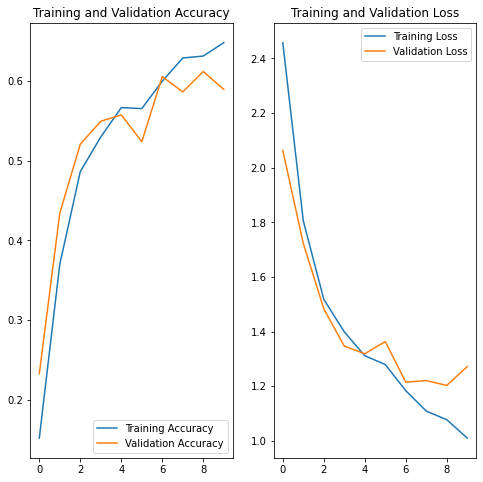

In [60]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()